In [95]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as plt
import random
import math

from typing import List, Tuple

In [96]:
# Cargamos el dataset de viento
datos = pd.read_excel('wind_data.xlsx')

# Visualizamos el dataset
datos.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


La funcion $\theta$ esta definida como:

$$
\theta(i) = 6 + 2cos(2πi/365)
$$

In [97]:
def theta_function(i):
    return 6 + 2 * np.cos(2 * np.pi * i / 365)


El error en la regresión lineal, conocido como RMSE (raiz del error cuadratico medio o root mean squared error), está definido como:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

In [98]:
def calcular_error(Y, predicciones):

    n = len(Y)

    residuos = Y - predicciones
    varianza = np.sum(residuos**2) / n

    return np.sqrt(varianza)

# Ejercicio 1

Vamos a estimar los parámetros $\kappa$ y $\sigma$ para el regresion_vientoo de velocidad del viento regional utilizando un regresion_vientoo de regresion lineal.

La ecuación original es:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

Despejamos $S_i$ para obtener una forma adecuada para la regresión lineal:

$$
S_{i+1} - S_i = \kappa \Delta (\theta(t_i) - S_i) + \sigma \sqrt{\Delta} Z_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
Y = \beta_1 X  + \epsilon_i
$$

donde:
- $Y = S_{i+1} - S_i$
- $\beta_1 = \kappa \Delta$
- $\epsilon_i = \sigma \sqrt{\Delta} Z_i$

In [99]:
datos['Y'] = datos['regional wind'].diff()  # Calcula la diferencia entre días consecutivos

# Preparar X, que es theta_i - S_i 
datos['X'] = theta_function(datos["dia"]) - datos['regional wind'].shift(1)

# Eliminar los valores nulos generados por diff() y shift()
datos = datos.dropna(subset=['Y', 'X'])

datos.head()

,dia,regional wind,wind gap norte sur,Y,X
1,2,8.346296,0.181523,0.346296,-0.001185
2,3,10.062316,0.188643,1.716019,-0.348963
3,4,10.791337,0.071085,0.729021,-2.067055
4,5,10.754093,0.078442,-0.037244,-2.798740
5,6,10.771457,0.642188,0.017364,-2.764751


### Regresion Lineal para el modelo del viento regional

In [100]:
Y = datos['Y']
X = datos[['X']]

regresion_viento = LinearRegression()
regresion_viento.fit(X, Y)

B0 = regresion_viento.intercept_
B1 = regresion_viento.coef_[0]

print(f"B0: {B0}")
print(f"B1: {B1}")

delta = 1/365

#Estimamos kappa
kappa_estimado = B1 / delta

#Estimamos sigma
predicciones = regresion_viento.predict(X)

error = calcular_error(Y,predicciones)

sigma_estimado = error / np.sqrt(delta)

print(f"kappa: {kappa_estimado}")
print(f"sigma: {sigma_estimado}")

B0: -0.010875737535769436
B1: 0.29791304777862465
kappa: 108.738262439198
sigma: 16.046573595261595


### Regresion Lineal para el modelo de diferencia de la velocidad del viento entre el norte y el sur

Vamos a estimar los parámetros $\beta$ y $\gamma$ para el regresion_vientoo de diferencia de la velocidad del viento entre el norte y el sur utilizando un modelo de regresion lineal.

La ecuación original es:

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

Despejamos $D_i$ para obtener una forma adecuada para la regresión lineal:

$$
D_{i+1} - D_i = - \beta \Delta D_i  + \gamma \sqrt{\Delta} W_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
H = \beta_1 G  + \epsilon_i
$$

donde:
- $H = D_{i+1} - D_i$
- $\beta_1 = -\beta \Delta$
- $\epsilon_i = \gamma \sqrt{\Delta} W_i$

In [101]:
# Preparar H
datos['H'] = datos['wind gap norte sur'].diff()

# Eliminar los valores nulos generados por diff()
datos = datos.dropna(subset = ('H'))

datos.head()

,dia,regional wind,wind gap norte sur,Y,X,H
2,3,10.062316,0.188643,1.716019,-0.348963,0.007120
3,4,10.791337,0.071085,0.729021,-2.067055,-0.117558
4,5,10.754093,0.078442,-0.037244,-2.798740,0.007358
5,6,10.771457,0.642188,0.017364,-2.764751,0.563745
6,7,9.527320,0.018175,-1.244136,-2.785959,-0.624012


In [102]:
G = datos[['wind gap norte sur']]
H = datos['H']

regresion_gap = LinearRegression()
regresion_gap.fit(G,H)

B0_2 = regresion_gap.intercept_
B1_2 = regresion_gap.coef_[0]

print(f"B0: {B0_2}")
print(f"B1: {B1_2}")

#Estimamos beta
beta_estimado = -B1_2 / delta

#Estimamos gamma

predicciones_gap = regresion_gap.predict(G)

error_gap = calcular_error(H,predicciones_gap)

gamma_estimado = error_gap / np.sqrt(delta)

print(f"beta: {beta_estimado}")
print(f"gamma: {gamma_estimado}")

B0: -0.00405730590765858
B1: 0.13254466625549013
beta: -48.3788031832539
gamma: 10.091915756839064


# Ejercicio 2

In [103]:
def generar_viento_regional(kappa, sigma, T):
    camino_viento = np.zeros(T)
    camino_viento[0] = datos['regional wind'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        Z = np.random.normal(0, 1)
        camino_viento[i] = camino_viento[i-1] + kappa * (theta_function(i) - camino_viento[i-1]) * 1/T + sigma * np.sqrt(1/T) * Z

    return camino_viento

def generar_gap_norte_sur(beta, gamma, T):
    camino_gap = np.zeros(T)
    camino_gap[0] = datos['wind gap norte sur'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        W = np.random.normal(0, 1)
        camino_gap[i] = camino_gap[i-1] + beta * 1/T * camino_gap[i-1] + gamma * np.sqrt(1/T) * W

    return camino_gap


In [104]:
import matplotlib.pyplot as plt

#Generamos 2 caminos con T = 365 uno para cada molino
T = 365

simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)

simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

simulacion_norte = simular_viento + simular_gap/2

simulacion_sur = simular_viento - simular_gap/2


$$
\text{Simulación Norte} = S_i + \frac{D_i}{2}
$$

$$
\text{Simulación Sur} = S_i - \frac{D_i}{2}
$$

Luego, si tomamos el promedio:

$$
\frac{\left(S_i + \frac{D_i}{2}\right) + \left(S_i - \frac{D_i}{2}\right)}{2} = S_i
$$

Simplificando:

$$
\frac{S_i + \frac{D_i}{2} + S_i - \frac{D_i}{2}}{2} = \frac{2S_i}{2} = S_i
$$

### Grafico comparativo del viento regional real vs el simulado

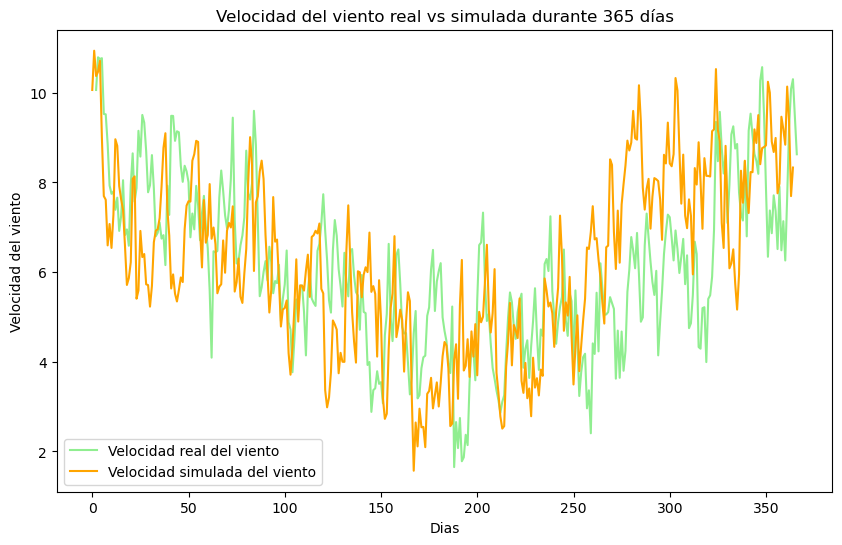

In [105]:
import matplotlib.pyplot as plt

# Graficar la velocidad del viento
plt.figure(figsize=(10, 6))
plt.plot(datos['regional wind'][:T], color='lightgreen', label='Velocidad real del viento')
plt.plot(simular_viento, color='orange', label='Velocidad simulada del viento')

# Añadir etiquetas y título
plt.xlabel('Dias')
plt.ylabel('Velocidad del viento')
plt.title('Velocidad del viento real vs simulada durante 365 días')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Vemos que en el largo plazo, hay una correlacion positiva entre ambos, por lo que resulta razonable pensar que el camino simulado se parece al camino real

### Grafico comparativo de la diferencia de velocidad del viento entre el norte y el sur real vs la simulada

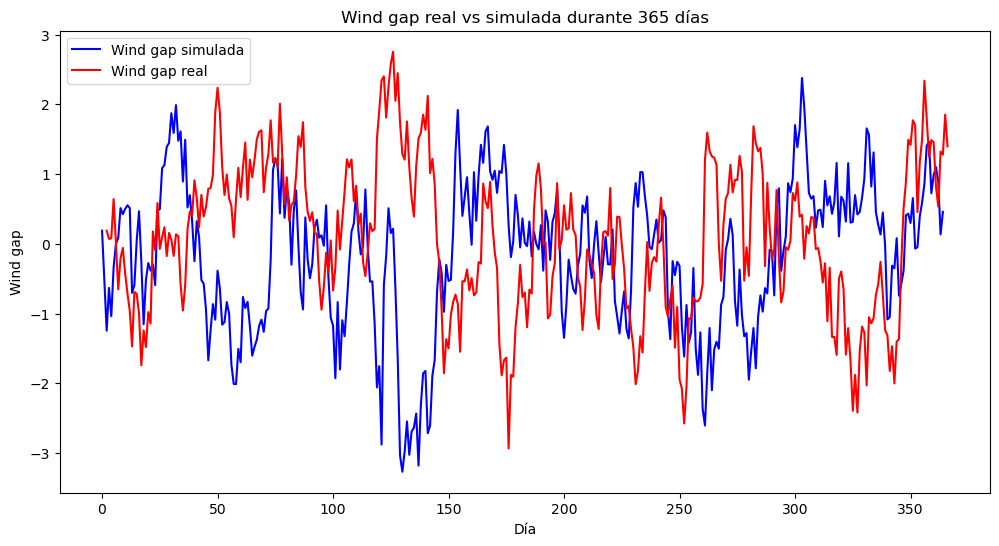

In [106]:
# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_gap, color='blue', label='Wind gap simulada')
plt.plot(datos["wind gap norte sur"][:T], color='red', label='Wind gap real')

plt.xlabel('Día')
plt.ylabel('Wind gap')
plt.title('Wind gap real vs simulada durante 365 días')
plt.legend()
plt.show()


### Gráfico comparativo de la velocidad simulada del viento para los molinos norte y sur

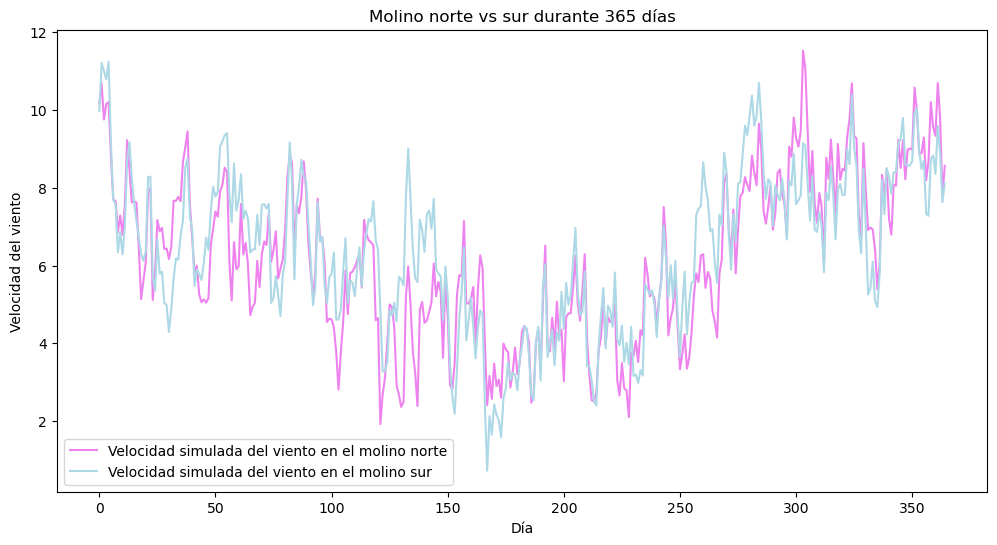

In [107]:
# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simulacion_norte, color='violet', label='Velocidad simulada del viento en el molino norte')
plt.plot(simulacion_sur, color='lightblue', label='Velocidad simulada del viento en el molino sur')

plt.xlabel('Día')
plt.ylabel('Velocidad del viento')
plt.title('Molino norte vs sur durante 365 días')
plt.legend()
plt.show()

Si bien hay periodos dentro del corto plazo donde la correlacion no es positiva, en el largo plazo ambos caminos se expanden de la misma manera, con correlación positiva

# Ejercicio 3

In [108]:
def simular_rotura(p):
    return 1 if random.uniform(0,1) < p else 0

def calcular_VAN(T, viento, k):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = math.exp(-0.05 * i / 365)
        estado_molino.append(activo)

        probabilidad_rotura = 0.25*(S[i]**2)*delta
        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                VAN -= 200000 * tasa_descuento
                activo = False
                rotura.append(1)
            
            else:

                rotura.append(0)

                if(S[i] >= k):
                    activo = False
                    VAN -= 1000 * tasa_descuento

                else:
                    VAN += 1000 * S[i] * tasa_descuento
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i] * tasa_descuento
        
            rotura.append(0)

        VAN_diario.append(VAN)
    
    return VAN_diario, estado_molino, rotura

def simular_ambos_molinos(sim_norte, sim_sur, T, k) -> List:

    VAN_molino_norte,estados_molino_norte,roturas_molino_norte = calcular_VAN(T,sim_norte,k)

    info_molino_norte = (VAN_molino_norte,estados_molino_norte,roturas_molino_norte)

    VAN_molino_sur,estados_molino_sur,roturas_molino_sur = calcular_VAN(T, sim_sur,k)

    info_molino_sur = (VAN_molino_sur,estados_molino_sur,roturas_molino_sur)

    return [info_molino_norte, info_molino_sur]

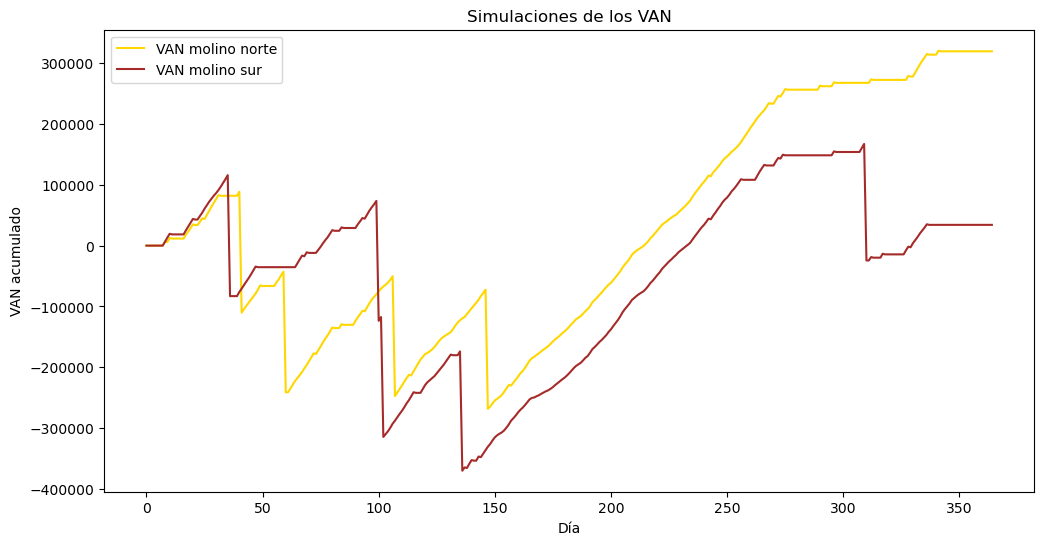

In [109]:
simulacion_ambos_molinos = simular_ambos_molinos(simulacion_norte,simulacion_sur,T,7)

simular_VAN_molino_norte = simulacion_ambos_molinos[0][0]

simular_VAN_molino_sur = simulacion_ambos_molinos[1][0]

# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_VAN_molino_norte, color='gold', label='VAN molino norte')
plt.plot(simular_VAN_molino_sur, color='brown', label='VAN molino sur')

plt.xlabel('Día')
plt.ylabel('VAN acumulado')
plt.title('Simulaciones de los VAN')
plt.legend()
plt.show()

# Ejercicio 4

In [110]:
def graficar_estado_molino(sim,roturas,encendido,region):
    # Datos ya calculados: simulacion_norte (velocidad del viento), simular_encendido_norte (estado de encendido) y simular_rotura_norte (roturas)
    dias = np.arange(len(sim))

    # Graficar la velocidad del viento
    plt.figure(figsize=(10, 6))
    plt.plot(dias, sim, color='orange', label='Velocidad simulada del viento', linewidth=0.85)

    # Graficar línea verde o roja según el valor de simular_encendido_norte
    for i in range(len(sim) - 1):
        if encendido[i] == 1:  # Encendido (True)
            plt.plot([dias[i], dias[i+1]], [sim[i], sim[i+1]], color='green', linewidth=2)
        else:  # Apagado (False)
            plt.plot([dias[i], dias[i+1]], [sim[i], sim[i+1]], color='red', linewidth=2)

    # Graficar roturas con puntos en la posición donde ocurre una rotura (simular_rotura_norte == 1)
    rotura_indices = np.where(np.array(roturas) == 1)[0]
    plt.scatter(rotura_indices, np.array(sim)[rotura_indices], color='blue', label=f'Rotura molino {region}', zorder=5)

    # Graficar línea horizontal en y = 9
    plt.axhline(y=7, color='black', linestyle='--', label='Umbral de apagado')

    # Añadir etiquetas y título
    plt.xlabel('Días')
    plt.ylabel('Velocidad del viento')
    plt.title('Velocidad del viento real vs simulada con estado de encendido y roturas')

    # Añadir leyenda
    plt.legend(['Velocidad simulada del viento', 'Encendido (verde) / Apagado (rojo)', f'Rotura molino {region}', 'Umbral de apagado'])

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

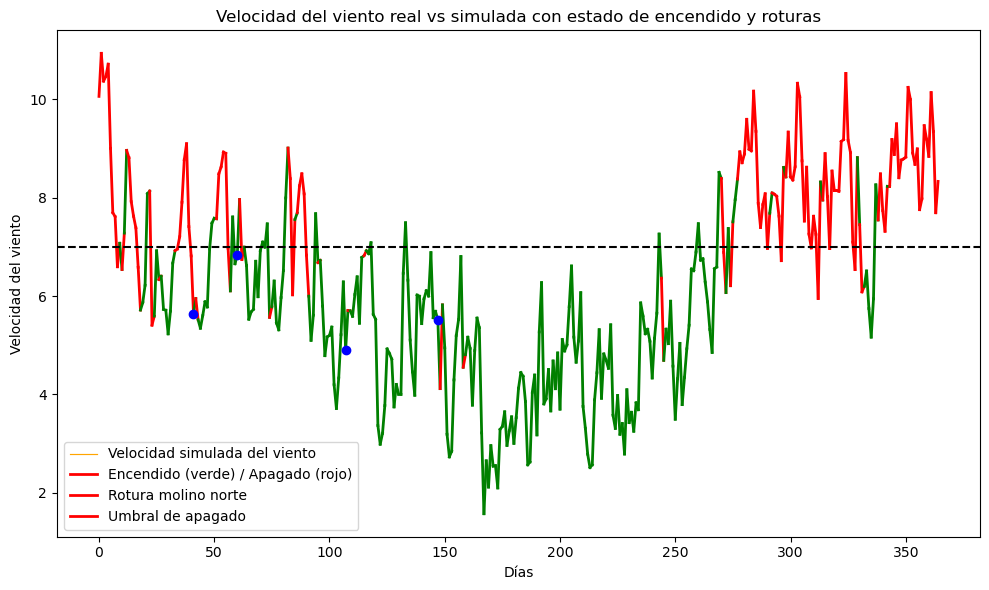

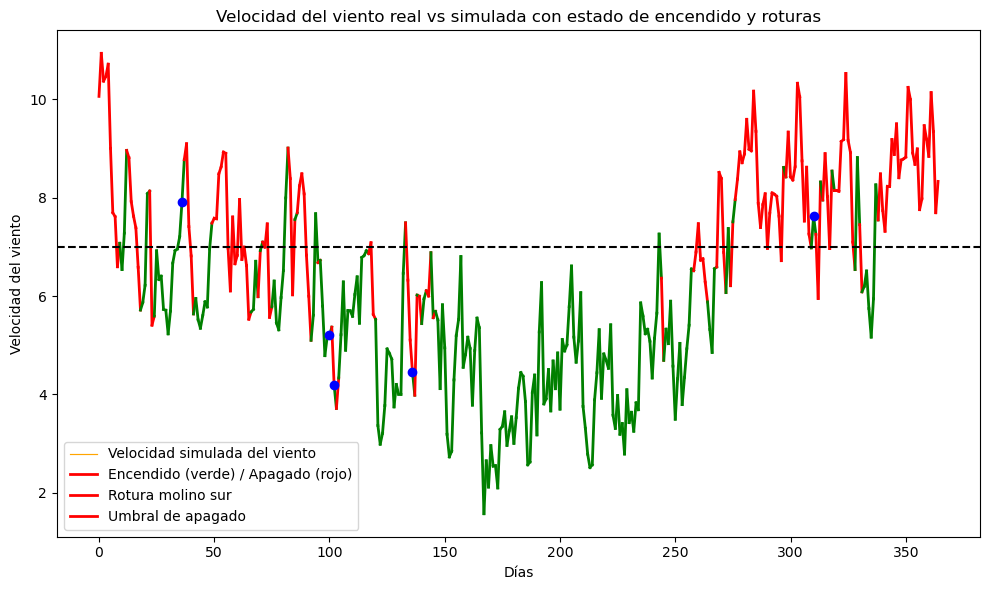

In [111]:
simular_encendido_norte = simulacion_ambos_molinos[0][1]

simular_rotura_norte = simulacion_ambos_molinos[0][2]

simular_norte = simulacion_ambos_molinos[0][0]

simular_encendido_sur = simulacion_ambos_molinos[1][1]

simular_rotura_sur = simulacion_ambos_molinos[1][2]

simular_sur = simulacion_ambos_molinos[1][0]

graficar_estado_molino(simular_viento,simular_rotura_norte,simular_encendido_norte,"norte")

graficar_estado_molino(simular_viento,simular_rotura_sur,simular_encendido_sur,"sur")


En el gráfico podemos observar como las 3 simulaciones se expanden de manera simetrica a traves del tiempo, esto nos lleva a pensar que los modelos implementados anteriormente son fieles a los datos proporcionados, mostrando una correlacion de largo plazo positiva.


A CHEQUEAR REY

# Ejercicio 5

El VAN esperado se calcula como el promedio de los VANs simulados:
$$
\text{VAN esperado} = \frac{1}{N} \sum_{j=1}^N \text{VAN}_j
$$

donde:
- N es el número total de simulaciones.
- $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.


In [112]:
def VAN_esperado(k, N, T):

    simulaciones_regionales = []

    for i in range(N):
        simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)
        simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

        camino_norte = simular_viento - simular_gap/2
        camino_sur = simular_viento + simular_gap/2

        VAN_norte = calcular_VAN(T, camino_norte, k)
        VAN_sur = calcular_VAN(T, camino_sur, k)

        simulaciones_regionales.append(VAN_norte + VAN_sur)

        VAN_esperado = np.mean(simulaciones_regionales)
        res = (VAN_esperado, k)

    return(res)



El error de estimación del VAN esperado se calcula en dos pasos:

1. **Calcular la Desviación Estándar de los VANs Simulados**:

   La fórmula para la desviación estándar $\sigma_{\text{VAN}}$ es:
   $$
   \sigma_{\text{VAN}} = \sqrt{\frac{1}{N-1} \sum_{j=1}^N (\text{VAN}_j - \text{VAN esperado})^2}
   $$

   Donde:
   - N es el número total de simulaciones.
   - $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.
   - $\text{VAN esperado}$ es el promedio de los VANs simulados.

2. **Calcular el Error Estándar del VAN Esperado**:

   La fórmula para el error estándar es:
   $$
   \text{Error estándar} = \frac{\sigma_{\text{VAN}}}{\sqrt{N}}
   $$

   Donde:
   - $\sigma_{\text{VAN}}$ es la desviación estándar de los VANs simulados.
   - N es el número total de simulaciones.


In [113]:
def estimar_error_VAN(VANs_simulados):
    # Supongamos que 'vans' es una lista o array de VANs simulados
    datos = VANs_simulados

    # Calcular la desviación estándar de los VANs simulados
    desviacion_estandar = np.std(datos, ddof=1)  # ddof=1 para obtener la desviación estándar muestral

    # Calcular el error estándar
    error_estandar = desviacion_estandar / np.sqrt(len(datos))

    return error_estandar


# Ejercicio 6

### Optimización del Umbral de Viento k para Maximizar el VAN

Queremos encontrar el valor del umbral de viento k que maximiza el Valor Actual Neto (VAN) generado por los molinos de viento en un año. Para ello, vamos utilizar simulaciones de Monte Carlo siguiendo estos pasos:

1. Definir un rango de valores de k
2. Implementar la simulación para calcular el VAN esperado para cada valor de k para N simulaciones.
3. Comparar los VANs obtenidos y seleccionar el k óptimo que maximice el VAN esperado.


In [114]:
N = 100

umbrales = np.arange(1, 12)
lista_VANs_norte = []
lista_VANs_sur = []
lista_VANs_total = []

# Llenar las listas con las tuplas de [VAN, k]
for k in umbrales:

    VAN_esperado_dado_k = VAN_esperado(k,N,T)[0]

    lista_VANs_total.append((VAN_esperado_dado_k,k))

# Encontrar el valor de k más alto considerando VAN y luego k
k_optimo_general = max(lista_VANs_total, key=lambda x: (x[0], x[1]))  # Max en función de [VAN, k]

print(f"El valor óptimo de k es: {k_optimo_general}")


El valor óptimo de k es: (47814.70196159212, 9)


# Ejercicio 7

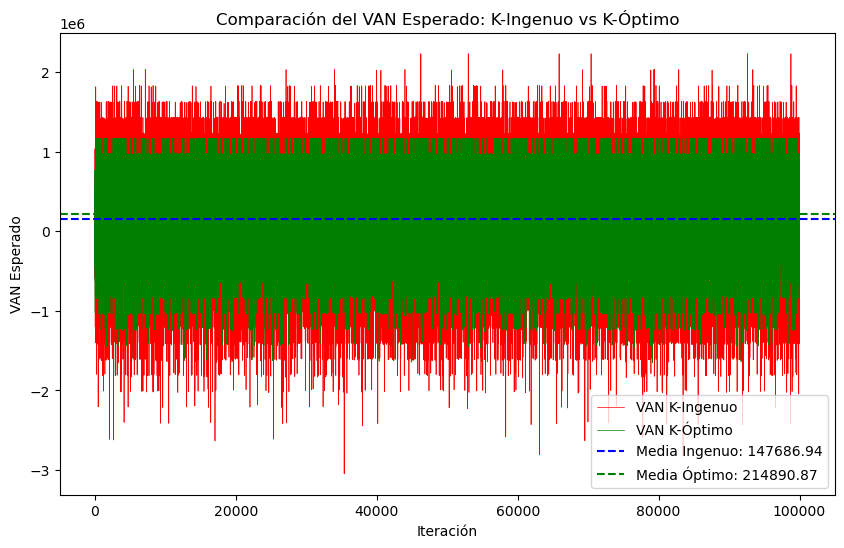

In [115]:
# Suponiendo que ya tienes las listas llenas con los valores
lista_van_k_optimo = []
lista_van_ingenua = []

for i in range(100000):
    VAN_esperado_ingenuo = calcular_VAN(T, simular_viento, 10000)[0][-1]
    VAN_esperado_optimo = calcular_VAN(T, simular_viento, 7)[0][-1]

    lista_van_k_optimo.append(VAN_esperado_optimo)
    lista_van_ingenua.append(VAN_esperado_ingenuo)

# Calcular las medias para referencia
media_ingenua = np.mean(lista_van_ingenua)
media_optimo = np.mean(lista_van_k_optimo)

# Graficar las dos listas
plt.figure(figsize=(10, 6))
plt.plot(lista_van_ingenua, label='VAN K-Ingenuo', color='red', linewidth = 0.5)
plt.plot(lista_van_k_optimo, label='VAN K-Óptimo', color='green', linewidth = 0.5)

# Graficar las líneas de las medias
plt.axhline(y=media_ingenua, color='blue', linestyle='--', label=f'Media Ingenuo: {media_ingenua:.2f}')
plt.axhline(y=media_optimo, color='green', linestyle='--', label=f'Media Óptimo: {media_optimo:.2f}')

# Añadir títulos y etiquetas
plt.title('Comparación del VAN Esperado: K-Ingenuo vs K-Óptimo')
plt.xlabel('Iteración')
plt.ylabel('VAN Esperado')
plt.legend()

# Mostrar la gráfica
plt.show()


# Ejercicio 8

El ingreso del mes de Agosto lo podemos medir el ingreso entre los días 213 (1 de Agosto) y 243 (31 de Agosto) de nuestro modelo

In [116]:
def calcular_VAN_sin_descuento(T, viento, k):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = 1
        estado_molino.append(activo)

        probabilidad_rotura = 0.25*(S[i]**2)*delta
        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                VAN -= 200000 * tasa_descuento
                activo = False
                rotura.append(1)
            
            else:

                rotura.append(0)

                if(S[i] >= k):
                    activo = False
                    VAN -= 1000 * tasa_descuento

                else:
                    VAN += 1000 * S[i] * tasa_descuento
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i] * tasa_descuento
        
            rotura.append(0)

        VAN_diario.append(VAN)
    
    return VAN_diario, estado_molino, rotura

In [117]:
ingresos_agosto = []

for i in range(100000):
    viento_agosto = generar_viento_regional(kappa_estimado,sigma_estimado,T)[213:244]
    ingreso_agosto = calcular_VAN_sin_descuento(len(viento_agosto),viento_agosto,7)

    ingresos_agosto.append(ingreso_agosto)

print(estimar_error_VAN(ingresos_agosto))

print(np.mean(ingresos_agosto))

813.3022001151062
-121368.19161523336


# Ejercicio 9

In [118]:
roturas_agosto_k_optimo = []

roturas_agosto_k_ingenuo = []

for i in range(100000):
    
    s_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)

    s_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

    s_norte = s_viento + s_gap/2

    s_sur = s_viento - s_gap/2

    b_k_optimo = simular_ambos_molinos(s_norte, s_sur, T, 7)

    b_k_ingenuo = simular_ambos_molinos(s_norte, s_sur, T, 100000)

    rotura_k_optimo = sum(b_k_optimo[0][2]) + sum(b_k_optimo[1][2])

    rotura_k_ingenuo = sum(b_k_ingenuo[0][2]) + sum(b_k_ingenuo[1][2])

    roturas_agosto_k_optimo.append(rotura_k_optimo)
    roturas_agosto_k_ingenuo.append(rotura_k_ingenuo)

print(np.mean(roturas_agosto_k_optimo)/2)

print(np.mean(roturas_agosto_k_ingenuo))


4.68438
19.16819


# Ejercicio 10

In [119]:
actividad_norte = []

actividad_sur = []

for i in range(10000):

    s_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)

    s_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

    s_norte = s_viento + s_gap/2

    s_sur = s_viento - s_gap/2

    b = simular_ambos_molinos(s_norte, s_sur, T, 7)

    estado_norte = sum(b[0][1])

    estado_sur = sum(b[1][1])

    actividad_norte.append(estado_norte)
    actividad_sur.append(estado_sur)

print(np.mean(actividad_norte))

print(np.mean(actividad_sur))

243.9703
243.9668


Tiene sentido este resultado, ya que 243/365 es 0.66, y dado que el viento suele oscilar entre 1 y 10, tiene sentido que el 66% de los días el molino esté activo

# Ejercicio 11

La proba de que esten los dos inactivos es la proba de que este inactivo el de norte * proba de que este inactivo el del sur. Calculamos la proporción de que esten inactivos el 9 de julio.

In [120]:
actividad_norte_9_julio = []

actividad_sur_9_julio = []

for i in range(10000):

    s_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)

    s_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

    s_norte = s_viento + s_gap/2

    s_sur = s_viento - s_gap/2

    b = simular_ambos_molinos(s_norte, s_sur, T, 7)

    estado_norte = b[0][1][189]

    estado_sur = b[1][1][189]

    actividad_norte_9_julio.append(estado_norte)
    actividad_sur_9_julio.append(estado_sur)

print(np.mean(actividad_norte))

print(np.mean(actividad_sur))

243.9703
243.9668


# Ejercicio 13

La sensibilidad se puede calcular utilizando diferencias finitas de la siguiente manera:

$$
\frac{\partial E[f(\alpha, S_T)]}{\partial \alpha} \approx \frac{E[f(\alpha + \epsilon, S_T)] - E[f(\alpha - \epsilon, S_T)]}{2\epsilon}
$$

Donde:
- $\alpha$ es el parámetro de interés.
- $\epsilon$ es un pequeño incremento.
- $E[f(\alpha, S_T)]$ es el valor esperado de la función \( f \) con el parámetro $\alpha$ y el proceso estocástico \( S_T \).

Para calcular esta sensibilidad, se realizan simulaciones para $\alpha$ + $\epsilon$ y $\alpha$ - $\epsilon$, y se utiliza la fórmula de diferencias finitas para estimar la derivada.

In [154]:
def calcular_VAN_modificado(T, viento, k, costo_arreglo):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = math.exp(-0.05 * i / 365)
        estado_molino.append(activo)

        probabilidad_rotura = 0.25 * (S[i]**2) * delta
        if activo:
            esta_roto = simular_rotura(probabilidad_rotura)

            if esta_roto:
                VAN -= costo_arreglo * tasa_descuento
                activo = False
                rotura.append(1)
            else:
                rotura.append(0)
                if S[i] >= k:
                    activo = False
                    VAN -= costo_arreglo * tasa_descuento
                else:
                    VAN += costo_arreglo * S[i] * tasa_descuento
        else:
            if S[i] < k:
                activo = True
                VAN += costo_arreglo * S[i] * tasa_descuento
            rotura.append(0)

        VAN_diario.append(VAN)
        print(f"Día {i}: VAN = {VAN}, Activo = {activo}, Rotura = {rotura[-1]}")

    return VAN_diario, estado_molino, rotura


In [155]:
def VAN_esperado_modificado(k, N, T, costo_arreglo):
    simulaciones_regionales = []

    for i in range(N):
        simular_viento = generar_viento_regional(kappa_estimado, sigma_estimado, T)
        simular_gap = generar_gap_norte_sur(beta_estimado, gamma_estimado, T)

        camino_norte = simular_viento - simular_gap / 2
        camino_sur = simular_viento + simular_gap / 2

        VAN_norte, _, _ = calcular_VAN_modificado(T, camino_norte, k, costo_arreglo)
        VAN_sur, _, _ = calcular_VAN_modificado(T, camino_sur, k, costo_arreglo)

        simulaciones_regionales.append(VAN_norte[-1] + VAN_sur[-1])

    VAN_esperado = np.mean(simulaciones_regionales)
    return VAN_esperado

In [ ]:
def calcular_sensibilidad(costo_arreglo_actual, costo_arreglo_nuevo, N, T, k):
    # Calcular VAN esperado para el costo de arreglo actual
    VAN_actual = VAN_esperado_modificado(k, N, T, costo_arreglo_actual)
    
    # Calcular VAN esperado para el nuevo costo de arreglo
    VAN_nuevo = VAN_esperado_modificado(k, N, T, costo_arreglo_nuevo)
    
    # Calcular la sensibilidad utilizando la fórmula de diferencias finitas
    sensibilidad = (VAN_nuevo - VAN_actual) / (costo_arreglo_nuevo - costo_arreglo_actual)
    
    return sensibilidad

costo_arreglo_actual = 200000  # Costo viejo
costo_arreglo_nuevo = 250000   # Nuevo costo
N = 10000
T = 365 
k = k_optimo_general

sensibilidad = calcular_sensibilidad(costo_arreglo_actual, costo_arreglo_nuevo, N, T, k)

print(f"La sensibilidad calculada es: {sensibilidad}")

In [ ]:
# Parámetros de entrada
N = 100
T = 365  # Horizonte temporal (días)
umbrales = np.arange(5, 12)

# Gráfico del cambio del VAN y el umbral óptimo para costos entre 200 y 250 mil dólares
costos_arreglo = np.linspace(200000, 250000, num=50)
VANs_esperados = []
umbrales_optimos = []

for costo in costos_arreglo:
    lista_VANs_total = []
    
    for k in umbrales:
        VAN_esperado_dado_k = VAN_esperado_modificado(k, N, T, costo)
        lista_VANs_total.append((VAN_esperado_dado_k, k))
    
    k_optimo_general = max(lista_VANs_total, key=lambda x: (x[0], x[1]))[1]
    
    umbrales_optimos.append(k_optimo_general)
    VANs_esperados.append(max(lista_VANs_total)[0])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(costos_arreglo, VANs_esperados)
plt.xlabel('Costo del Arreglo')
plt.ylabel('VAN Esperado')
plt.title('Cambio del VAN Esperado con el Costo del Arreglo')

plt.subplot(1, 2, 2)
plt.plot(costos_arreglo, umbrales_optimos)
plt.xlabel('Costo del Arreglo')
plt.ylabel('Umbral Óptimo (k)')
plt.title('Cambio del Umbral Óptimo con el Costo del Arreglo')

plt.tight_layout()
plt.show()

El gráfico muestra una relación positiva entre el costo del arreglo y el VAN esperado. Esto indica que a medida que aumenta el costo del arreglo, el VAN esperado también aumenta. Esto puede tener sentido si consideramos que un mayor costo de arreglo podría estar asociado con una mayor inversión en mantenimiento, lo que podría mejorar la eficiencia y el rendimiento de los molinos, resultando en un mayor VAN.

El gráfico muestra que el umbral óptimo (k) permanece constante a pesar de los cambios en el costo del arreglo. Esto sugiere que el valor óptimo de k no se ve afectado por el costo del arreglo dentro del rango considerado (200000 a 250000 dólares). Esto puede ser razonable si el umbral óptimo depende más de otros factores, como las condiciones del viento y la probabilidad de rotura, que del costo del arreglo.